In [1]:
# https://data.sfgov.org/Public-Safety/Map-Crime-Incidents-from-1-Jan-2003/gxxq-x39z
from datetime import date, time, datetime, timedelta
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
import statsmodels.formula.api as smf
import math

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\morebeus\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%%time
sfcrime = pd.read_csv("Map_of_SFPD_Incidents_-_from_1_Jan_2003.csv")
print sfcrime.head(5)

   IncidntNum       Category           Descript  DayOfWeek  \
0   150098373  VEHICLE THEFT  STOLEN AUTOMOBILE     Sunday   
1   150098464  VEHICLE THEFT  STOLEN AUTOMOBILE     Sunday   
2   150098715  VEHICLE THEFT  STOLEN AUTOMOBILE     Sunday   
3   150098743  VEHICLE THEFT  STOLEN AUTOMOBILE  Wednesday   
4   150099086  VEHICLE THEFT       STOLEN TRUCK     Sunday   

                     Date   Time PdDistrict Resolution  \
0  02/01/2015 12:00:00 AM  12:45   NORTHERN       NONE   
1  02/01/2015 12:00:00 AM  11:45   NORTHERN       NONE   
2  02/01/2015 12:00:00 AM  08:00   RICHMOND  UNFOUNDED   
3  01/28/2015 12:00:00 AM  16:00    TARAVAL       NONE   
4  02/01/2015 12:00:00 AM  01:00  INGLESIDE       NONE   

                       Address           X          Y  \
0        FRANKLIN ST / TURK ST -122.422277  37.781753   
1        GROVE ST / VANNESS AV -122.419885  37.778251   
2  GOLDEN GATE AV / STANYAN ST -122.455126  37.777024   
3         LINCOLN WY / 38TH AV -122.497614  37.764

In [3]:
%%time
sfcrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120514 entries, 0 to 120513
Data columns (total 12 columns):
IncidntNum    120514 non-null int64
Category      120514 non-null object
Descript      120514 non-null object
DayOfWeek     120514 non-null object
Date          120514 non-null object
Time          120514 non-null object
PdDistrict    120514 non-null object
Resolution    120514 non-null object
Address       120514 non-null object
X             120514 non-null float64
Y             120514 non-null float64
Location      120514 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 11.0+ MB
Wall time: 180 ms


In [4]:
%%time
sfcrime.columns

Wall time: 0 ns


Index([u'IncidntNum', u'Category', u'Descript', u'DayOfWeek', u'Date', u'Time',
       u'PdDistrict', u'Resolution', u'Address', u'X', u'Y', u'Location'],
      dtype='object')

In [5]:
%%time
# Evaluates the Resolution column to match 'NONE' to TRUE/FALSE
res = sfcrime.Resolution == 'NONE'

# initially set Size to small, then change roughly half to be large
sfcrime['Resolve'] = 1
sfcrime.loc[res, 'Resolve'] = 0
sfcrime.head(10)

Wall time: 37 ms


In [6]:
%%time
col_find = 'Resolve'
print sfcrime[col_find].value_counts(normalize = True)

0    0.917238
1    0.082762
Name: Resolve, dtype: float64
Wall time: 7 ms


In [7]:
%%time
sfcrime_VT = sfcrime[sfcrime.Category == 'VEHICLE THEFT']

Wall time: 146 ms


In [8]:
%%time
sfcrime_VT.head(10)

Wall time: 1 ms


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,Resolve
0,150098373,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/01/2015 12:00:00 AM,12:45,NORTHERN,NONE,FRANKLIN ST / TURK ST,-122.422277,37.781753,"(37.7817528767881, -122.42227702764)",0
1,150098464,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/01/2015 12:00:00 AM,11:45,NORTHERN,NONE,GROVE ST / VANNESS AV,-122.419885,37.778251,"(37.7782510832412, -122.419884939457)",0
2,150098715,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/01/2015 12:00:00 AM,08:00,RICHMOND,UNFOUNDED,GOLDEN GATE AV / STANYAN ST,-122.455126,37.777024,"(37.777023633257, -122.455125552189)",1
3,150098743,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,01/28/2015 12:00:00 AM,16:00,TARAVAL,NONE,LINCOLN WY / 38TH AV,-122.497614,37.764543,"(37.7645433165084, -122.49761402653)",0
4,150099086,VEHICLE THEFT,STOLEN TRUCK,Sunday,02/01/2015 12:00:00 AM,01:00,INGLESIDE,NONE,CRESCENT AV / PORTER ST,-122.418099,37.734953,"(37.7349529289018, -122.418098776629)",0
5,150099230,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/01/2015 12:00:00 AM,18:00,CENTRAL,NONE,500 Block of COLUMBUS AV,-122.409576,37.799952,"(37.7999519603954, -122.409576373262)",0
6,150099406,VEHICLE THEFT,STOLEN TRUCK,Sunday,02/01/2015 12:00:00 AM,20:00,MISSION,NONE,24TH ST / LILAC ST,-122.417878,37.752273,"(37.7522731644848, -122.417878226786)",0
7,150100570,VEHICLE THEFT,STOLEN AUTOMOBILE,Sunday,02/01/2015 12:00:00 AM,00:05,PARK,NONE,BAKER ST / FELL ST,-122.440924,37.773635,"(37.7736351065468, -122.440923876434)",0
8,140071185,VEHICLE THEFT,STOLEN AUTOMOBILE,Thursday,01/23/2014 12:00:00 AM,18:00,TARAVAL,NONE,WILSON ST / RHINE ST,-122.461139,37.709085,"(37.7090849156407, -122.461139183524)",0
9,150100940,VEHICLE THEFT,STOLEN TRUCK,Monday,02/02/2015 12:00:00 AM,09:15,NORTHERN,NONE,1900 Block of LARKIN ST,-122.419956,37.795683,"(37.7956830656712, -122.419955910836)",0


In [9]:
%%time
# Extract feature columns
feature_cols = list(sfcrime_VT.drop(['Category', 'Address', 'Location', 'Resolution'], axis=1))

# Extract target column 'passed'
target_col = sfcrime_VT.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = sfcrime_VT[feature_cols]
y_all = sfcrime_VT[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()
target_col

Feature columns:
['IncidntNum', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'X', 'Y', 'Resolve']

Target column: Resolve

Feature values:
   IncidntNum           Descript  DayOfWeek                    Date   Time  \
0   150098373  STOLEN AUTOMOBILE     Sunday  02/01/2015 12:00:00 AM  12:45   
1   150098464  STOLEN AUTOMOBILE     Sunday  02/01/2015 12:00:00 AM  11:45   
2   150098715  STOLEN AUTOMOBILE     Sunday  02/01/2015 12:00:00 AM  08:00   
3   150098743  STOLEN AUTOMOBILE  Wednesday  01/28/2015 12:00:00 AM  16:00   
4   150099086       STOLEN TRUCK     Sunday  02/01/2015 12:00:00 AM  01:00   

  PdDistrict           X          Y  Resolve  
0   NORTHERN -122.422277  37.781753        0  
1   NORTHERN -122.419885  37.778251        0  
2   RICHMOND -122.455126  37.777024        1  
3    TARAVAL -122.497614  37.764543        0  
4  INGLESIDE -122.418099  37.734953        0  
Wall time: 63 ms


In [10]:
%%time
col_find = 'Descript'
print sfcrime_VT[col_find].value_counts(normalize = True)

STOLEN AUTOMOBILE                                  0.511003
STOLEN TRUCK                                       0.165076
VEHICLE, RECOVERED, AUTO                           0.134947
STOLEN MOTORCYCLE                                  0.049040
STOLEN AND RECOVERED VEHICLE                       0.043489
VEHICLE, RECOVERED, OTHER VEHICLE                  0.042244
RECOVERED VEHICLE - STOLEN OUTSIDE SF              0.026910
ATTEMPTED STOLEN VEHICLE                           0.009294
VEHICLE, RECOVERED, MOTORCYCLE                     0.007053
TAMPERING WITH A VEHICLE                           0.004016
STOLEN MISCELLANEOUS VEHICLE                       0.003551
AUTO, GRAND THEFT OF                               0.001162
STOLEN TRAILER                                     0.000971
VEHICLE, RECOVERED, CAMPER-HOUSE CAR-MOTOR HOME    0.000631
VEHICLE, RENTAL, FAILURE TO RETURN                 0.000232
VEHICLE, RECOVERED, MOBILE HOME-TRAILER            0.000207
STOLEN BUS                              

In [11]:
%%time
print sfcrime_VT[col_find].value_counts().count()

18
Wall time: 20 ms


In [12]:
%%time
X_all['Date'] = pd.to_datetime(X_all.Date)
# X_all.set_index('Date', inplace=True)

Wall time: 1min 28s


C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
%%time
X_all.head(5)

Wall time: 0 ns


,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,Resolve
0,150098373,STOLEN AUTOMOBILE,Sunday,2015-02-01,12:45,NORTHERN,-122.422277,37.781753,0
1,150098464,STOLEN AUTOMOBILE,Sunday,2015-02-01,11:45,NORTHERN,-122.419885,37.778251,0
2,150098715,STOLEN AUTOMOBILE,Sunday,2015-02-01,08:00,RICHMOND,-122.455126,37.777024,1
3,150098743,STOLEN AUTOMOBILE,Wednesday,2015-01-28,16:00,TARAVAL,-122.497614,37.764543,0
4,150099086,STOLEN TRUCK,Sunday,2015-02-01,01:00,INGLESIDE,-122.418099,37.734953,0


In [14]:
# loop through all Time per Date
# for t in range(0, len(X_all['Time'])):
#     X_all['Time'][t] = pd.to_datetime(X_all.Time[t], format="%H:%M").strftime("%H:%M")
#     X_all['Date_Time'][t] = X_all['Date'][t].strftime("%m/%d%y") + ' ' + X_all['Time'][t]

# Single Date change to string
# X_all['Time'][10] = pd.to_datetime(X_all.Time[10], format="%H:%M").strftime("%H:%M")
# X_all['Time'][10]

In [15]:
# X_all.set_index(['Date', 'Time'], inplace=True)

In [16]:
%%time
X_all = X_all.sort(['Date', 'Time'])

C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


Wall time: 220 ms


In [17]:
%%time
X_all.head(10)

Wall time: 1e+03 µs


,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,Resolve
57805,30001034,STOLEN AND RECOVERED VEHICLE,Wednesday,2003-01-01,00:45,RICHMOND,-122.501331,37.779521,0
23333,40502834,"VEHICLE, RECOVERED, MOTORCYCLE",Wednesday,2003-01-01,09:00,TARAVAL,-122.454020,37.719106,0
38787,71113141,STOLEN TRUCK,Wednesday,2003-01-01,09:00,BAYVIEW,-122.383013,37.745994,0
42258,40502834,STOLEN MOTORCYCLE,Wednesday,2003-01-01,09:00,TARAVAL,-122.454020,37.719106,0
51855,30001573,RECOVERED VEHICLE - STOLEN OUTSIDE SF,Wednesday,2003-01-01,10:00,PARK,-122.457037,37.767771,0
18475,30001987,STOLEN AUTOMOBILE,Wednesday,2003-01-01,10:30,RICHMOND,-122.466205,37.772541,0
33725,30001987,"VEHICLE, RECOVERED, OTHER VEHICLE",Wednesday,2003-01-01,10:30,RICHMOND,-122.466205,37.772541,0
44145,30001987,STOLEN TRUCK,Wednesday,2003-01-01,10:30,RICHMOND,-122.466205,37.772541,0
107637,21347419,"VEHICLE, RECOVERED, OTHER VEHICLE",Wednesday,2003-01-01,12:36,INGLESIDE,-122.418157,37.742204,0
41858,30002098,RECOVERED VEHICLE - STOLEN OUTSIDE SF,Wednesday,2003-01-01,12:59,BAYVIEW,-122.387244,37.719513,0


In [18]:
%%time
X_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120514 entries, 57805 to 119743
Data columns (total 9 columns):
IncidntNum    120514 non-null int64
Descript      120514 non-null object
DayOfWeek     120514 non-null object
Date          120514 non-null datetime64[ns]
Time          120514 non-null object
PdDistrict    120514 non-null object
X             120514 non-null float64
Y             120514 non-null float64
Resolve       120514 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 9.2+ MB
Wall time: 87 ms


In [19]:
%%time
X_all.columns

Wall time: 0 ns


Index([u'IncidntNum', u'Descript', u'DayOfWeek', u'Date', u'Time',
       u'PdDistrict', u'X', u'Y', u'Resolve'],
      dtype='object')

In [20]:
%%time
X_all.head(5)

Wall time: 2 ms


,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,Resolve
57805,30001034,STOLEN AND RECOVERED VEHICLE,Wednesday,2003-01-01,00:45,RICHMOND,-122.501331,37.779521,0
23333,40502834,"VEHICLE, RECOVERED, MOTORCYCLE",Wednesday,2003-01-01,09:00,TARAVAL,-122.454020,37.719106,0
38787,71113141,STOLEN TRUCK,Wednesday,2003-01-01,09:00,BAYVIEW,-122.383013,37.745994,0
42258,40502834,STOLEN MOTORCYCLE,Wednesday,2003-01-01,09:00,TARAVAL,-122.454020,37.719106,0
51855,30001573,RECOVERED VEHICLE - STOLEN OUTSIDE SF,Wednesday,2003-01-01,10:00,PARK,-122.457037,37.767771,0


In [21]:
%%time
'''Change the amount of data analyzed by date in red.  The commented date is if the Date and Time are indexed first.'''
X_new = X_all[X_all.Date > '2015-12-31']
# X_new = X_all[('2006-01-01','00:00'):]
X_new.head(10)
print len(X_new)
print X_new.head(10)

7540
        IncidntNum                      Descript DayOfWeek       Date   Time  \
114869   160355997             STOLEN AUTOMOBILE    Friday 2016-01-01  00:01   
12207    160001225             STOLEN AUTOMOBILE    Friday 2016-01-01  01:30   
111473   160007994             STOLEN AUTOMOBILE    Friday 2016-01-01  09:00   
113334   160095820  STOLEN AND RECOVERED VEHICLE    Friday 2016-01-01  09:00   
113335   160095820  STOLEN MISCELLANEOUS VEHICLE    Friday 2016-01-01  09:00   
111450   160006435             STOLEN AUTOMOBILE    Friday 2016-01-01  11:00   
9269     160001899                  STOLEN TRUCK    Friday 2016-01-01  11:30   
12434    160001407             STOLEN AUTOMOBILE    Friday 2016-01-01  11:50   
10306    160002687                  STOLEN TRUCK    Friday 2016-01-01  12:00   
111484   160009417             STOLEN MOTORCYCLE    Friday 2016-01-01  12:00   

       PdDistrict           X          Y  Resolve  
114869    BAYVIEW -122.378392  37.732331        1  
12207    S

In [22]:
%%time
# X_new.head(10)
X_all[X_all.IncidntNum == 110003748]

Wall time: 2 ms


,IncidntNum,Descript,DayOfWeek,Date,Time,PdDistrict,X,Y,Resolve
34234,110003748,STOLEN AND RECOVERED VEHICLE,Saturday,2011-01-01,22:00,SOUTHERN,-122.409504,37.781526,0
53580,110003748,STOLEN TRUCK,Saturday,2011-01-01,22:00,SOUTHERN,-122.409504,37.781526,0


In [23]:
%%time
X_dates = X_new[['Date', 'Time', 'IncidntNum']]
X_new = X_new.drop(['Date', 'Time'], axis=1)
print len(X_dates)
print len(X_new)

7540
7540
Wall time: 5 ms


In [24]:
# Drop duplicates -- Did not work
# merge with index

In [25]:
%%time
def preprocess_features(X):
    ''' Preprocesses the default data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        print "Processing %s" % col
        if col == 'Date':
            print "skip Date"
        # If data type is non-numeric, replace all yes/no values with 1/0
        elif col == 'Time':
            print "skip Time"
        else:
            if col_data.dtype == float:
                print "skip %s float64" % col
            if col_data.dtype == object:
                print "Convert Yes/No"
                col_data = col_data.replace(['yes', 'no'], [1, 0])
                # If data type is categorical, convert to dummy variables
            if col_data.dtype == object:
                print "Convert to Dummies Variables"
                # Example: 'school' => 'school_GP' and 'school_MS'
                col_data = pd.get_dummies(col_data, prefix = col)
        
        print "Completed %s" % col 
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_new = preprocess_features(X_new)
print "Processed feature columns ({} total features):\n{}".format(len(X_new.columns), list(X_new.columns))

Processing IncidntNum
Completed IncidntNum
Processing Descript
Convert Yes/No
Convert to Dummies Variables
Completed Descript
Processing DayOfWeek
Convert Yes/No
Convert to Dummies Variables
Completed DayOfWeek
Processing PdDistrict
Convert Yes/No
Convert to Dummies Variables
Completed PdDistrict
Processing X
skip X float64
Completed X
Processing Y
skip Y float64
Completed Y
Processing Resolve
Completed Resolve
Processed feature columns (31 total features):
['IncidntNum', 'Descript_ATTEMPTED STOLEN VEHICLE', 'Descript_AUTO, GRAND THEFT OF', 'Descript_STOLEN AND RECOVERED VEHICLE', 'Descript_STOLEN AUTOMOBILE', 'Descript_STOLEN BUS', 'Descript_STOLEN MISCELLANEOUS VEHICLE', 'Descript_STOLEN MOTORCYCLE', 'Descript_STOLEN TRAILER', 'Descript_STOLEN TRUCK', 'Descript_VEHICLE, RENTAL, FAILURE TO RETURN', 'DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL

In [26]:
# X_new.X.dtype == float

In [27]:
%%time
X_new.head(10)

Wall time: 2 ms


,IncidntNum,Descript_ATTEMPTED STOLEN VEHICLE,"Descript_AUTO, GRAND THEFT OF",Descript_STOLEN AND RECOVERED VEHICLE,Descript_STOLEN AUTOMOBILE,Descript_STOLEN BUS,Descript_STOLEN MISCELLANEOUS VEHICLE,Descript_STOLEN MOTORCYCLE,Descript_STOLEN TRAILER,Descript_STOLEN TRUCK,...,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,Resolve
114869,160355997,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-122.378392,37.732331,1
12207,160001225,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,-122.395481,37.788093,0
111473,160007994,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,-122.454780,37.713148,1
113334,160095820,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-122.398465,37.744072,0
113335,160095820,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,-122.398465,37.744072,0
111450,160006435,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,-122.443954,37.796967,0
9269,160001899,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,-122.511294,37.775073,1
12434,160001407,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-122.421644,37.742997,0
10306,160002687,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,-122.443650,37.770426,1
111484,160009417,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,-122.420857,37.740221,0


In [28]:
%%time
X_dates.set_index('IncidntNum', inplace=True)
X_new.set_index('IncidntNum', inplace=True)
X_combine = X_dates.join(X_new, how = 'inner')
X_combine.drop_duplicates(inplace=True)
X_combine.sort(['Date', 'Time'], inplace=True)

Wall time: 122 ms


C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [29]:
# X_new.drop_duplicates(inplace=True)
# X_new.info()

In [30]:
%%time
X_combine

Wall time: 0 ns


,Date,Time,Descript_ATTEMPTED STOLEN VEHICLE,"Descript_AUTO, GRAND THEFT OF",Descript_STOLEN AND RECOVERED VEHICLE,Descript_STOLEN AUTOMOBILE,Descript_STOLEN BUS,Descript_STOLEN MISCELLANEOUS VEHICLE,Descript_STOLEN MOTORCYCLE,Descript_STOLEN TRAILER,...,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,Resolve
IncidntNum,,,,,,,,,,,,,,,,,,,,,
160355997,2016-01-01,00:01,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-122.378392,37.732331,1
160001225,2016-01-01,01:30,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,-122.395481,37.788093,0
160007994,2016-01-01,09:00,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,-122.454780,37.713148,1
160095820,2016-01-01,09:00,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-122.398465,37.744072,0
160095820,2016-01-01,09:00,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,-122.398465,37.744072,0
160006435,2016-01-01,11:00,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-122.443954,37.796967,0
160001899,2016-01-01,11:30,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,-122.511294,37.775073,1
160001407,2016-01-01,11:50,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,-122.421644,37.742997,0
160002687,2016-01-01,12:00,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,-122.443650,37.770426,1


In [31]:
# 1) Create a Regression model to predict Resolution
# 2) Create a model to find the K-mean categories
# 3) Create a model that uses the K-means to predict Resolution
# 4) Create additional columns Magnitude and Degrees by grouping Date and K-mean and calculating the Magnitude and Degrees
# 5) Create a model to predict the Magnitude
# 6) Create a model to predict the Degrees
# 7) Summarize findings

In [32]:
%%time
X_combine.set_index(['Date', 'Time'], inplace=True)

Wall time: 5 ms


In [33]:
%%time
X_combine.head(10)

Wall time: 1e+03 µs


Descript_ATTEMPTED STOLEN VEHICLE  \
Date       Time                                       
2016-01-01 00:01                                  0   
           01:30                                  0   
           09:00                                  0   
           09:00                                  0   
           09:00                                  0   
           11:00                                  0   
           11:30                                  0   
           11:50                                  0   
           12:00                                  0   
           12:00                                  0   

                  Descript_AUTO, GRAND THEFT OF  \
Date       Time                                   
2016-01-01 00:01                              0   
           01:30                              0   
           09:00                              0   
           09:00                              0   
           09:00                              0   
           11:00                              0   
           11:30                              0   
           11:50                              0   
           12:00                              0   
           12:00                              0   

                  Descript_STOLEN AND RECOVERED VEHICLE  \
Date       Time                                           
2016-01-01 00:01                                      0   
           01:30                                      0   
           09:00                                      0   
           09:00                                      1   
           09:00                                      0   
           11:00                                      0   
           11:30                                      0   
           11:50                                      0   
           12:00                                      0   
           12:00                                      0   

                  Descript_STOLEN AUTOMOBILE  Descript_STOLEN BUS  \
Date       Time                                                     
2016-01-01 00:01                           1                    0   
           01:30                           1                    0   
           09:00                           1                    0   
           09:00                           0                    0   
           09:00                           0                    0   
           11:00                           1                    0   
           11:30                           0                    0   
           11:50                           1                    0   
           12:00                           0                    0   
           12:00                           0                    0   

                  Descript_STOLEN MISCELLANEOUS VEHICLE  \
Date       Time                                           
2016-01-01 00:01                                      0   
           01:30                                      0   
           09:00                                      0   
           09:00                                      0   
           09:00                                      1   
           11:00                                      0   
           11:30                                      0   
           11:50                                      0   
           12:00                                      0   
           12:00                                      0   

                  Descript_STOLEN MOTORCYCLE  Descript_STOLEN TRAILER  \
Date       Time                                                         
2016-01-01 00:01                           0                        0   
           01:30                           0                        0   
           09:00                           0                        0   
           09:00                           0                        0   
           09:00                           0               

In [34]:
%%time
# Extract feature columns
feature_cols = list(X_combine.drop(['Resolve'], axis=1))

# Extract target column 'passed'
target_col = X_combine.columns[-1]

# Number of features
num_features = len(feature_cols)

# Show the list of columns
print "Number of Features: {}".format(num_features)
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

Number of Features: 29
Feature columns:
['Descript_ATTEMPTED STOLEN VEHICLE', 'Descript_AUTO, GRAND THEFT OF', 'Descript_STOLEN AND RECOVERED VEHICLE', 'Descript_STOLEN AUTOMOBILE', 'Descript_STOLEN BUS', 'Descript_STOLEN MISCELLANEOUS VEHICLE', 'Descript_STOLEN MOTORCYCLE', 'Descript_STOLEN TRAILER', 'Descript_STOLEN TRUCK', 'Descript_VEHICLE, RENTAL, FAILURE TO RETURN', 'DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN', 'X', 'Y']

Target column: Resolve
Wall time: 4 ms


In [35]:
%%time
# fit a linear regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
X = X_combine[feature_cols]
y = X_combine[target_col]

model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
print model.score(X, y)

0.917586069387
Wall time: 544 ms


Wall time: 1.19 s


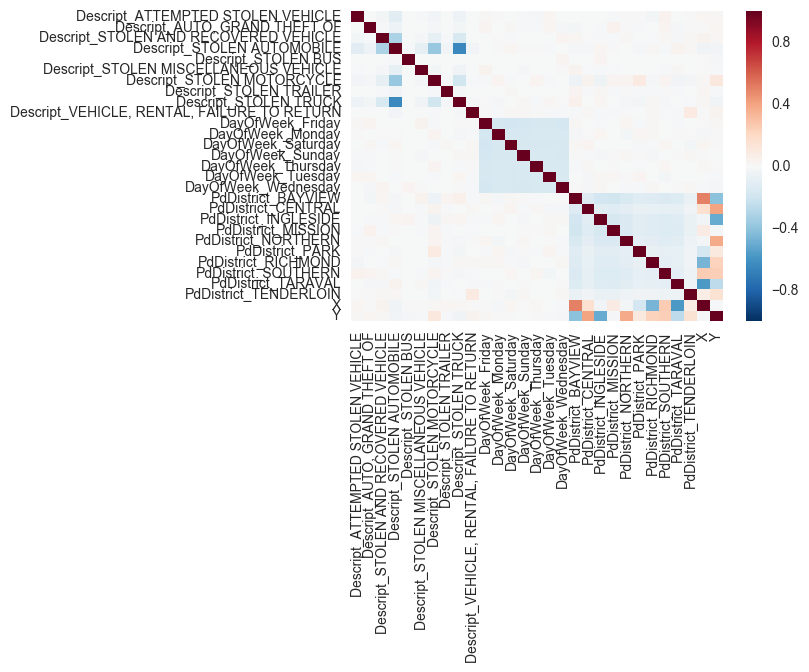

In [36]:
%%time
sb.heatmap(X.corr())

C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Wall time: 596 ms


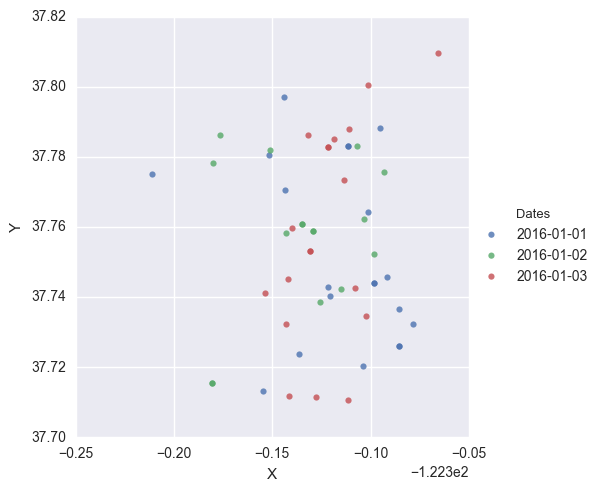

In [37]:
%%time
date_start = '2016-01-01'
date_end = '2016-01-03'
days = pd.to_datetime(date_end) - pd.to_datetime(date_start)
days = days.days
plot_data = X_combine[(date_start):(date_end)]
dates = []

for i in range(0, days + 1):
    each_day = (pd.to_datetime(date_start) + timedelta(days=i)).strftime("%Y-%m-%d")
    dates.append([each_day] * len(X_combine[(each_day):(each_day)]))

dates = [y for x in dates for y in x]

X_plot = plot_data[['X','Y']]
X_plot['Dates'] = dates
# print len(dates)
# print len(X_plot)
# print X_plot

sb.lmplot('X', 'Y',
           data=X_plot,
           fit_reg=False,
           hue='Dates'
         )

In [38]:
%%time
'''K-means to classify groups of Vehicle Thefts'''
# K-means with 3 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=13, random_state=42)
# km = KMeans(n_clusters=6, random_state=1)
km.fit(X_combine)

Wall time: 4.1 s


In [39]:
%%time
km.labels_

Wall time: 0 ns


array([8, 8, 8, ..., 9, 6, 6])

In [40]:
%%time
X_combine['cluster'] = km.labels_
X_combine.sort_values(by='cluster')

Wall time: 131 ms


In [41]:
%%time
km.cluster_centers_

Wall time: 0 ns


array([[  9.72447326e-03,   2.51534904e-17,  -7.63278329e-16,
          8.80064830e-01,   4.06575815e-19,   4.86223663e-03,
          1.00486224e-01,   1.62074554e-03,   1.38777878e-15,
          3.24149109e-03,  -1.36002321e-15,  -9.15933995e-16,
          1.38777878e-16,   1.00000000e+00,  -8.04911693e-16,
         -1.49880108e-15,  -1.13797860e-15,   1.96110211e-01,
          8.58995138e-02,   1.41004862e-01,   1.62074554e-01,
         -6.10622664e-16,   9.72447326e-02,   8.26580227e-02,
          1.02106969e-01,   9.72447326e-02,   3.56564019e-02,
         -1.22425958e+02,   3.77573447e+01,   7.61750405e-02],
       [  1.16226473e-16,  -2.68882139e-17,  -8.32667268e-16,
          1.25455202e-14,   4.06575815e-19,   7.80625564e-17,
          1.09634524e-15,   3.25260652e-18,   1.00000000e+00,
          1.73472348e-18,   1.84699454e-01,   1.42076503e-01,
          1.57377049e-01,   1.97814208e-01,   1.37704918e-01,
          1.80327869e-01,  -1.47104551e-15,   2.38697950e-15,
       

In [42]:
%%time
# calculate the mean of each feature for each cluster
X_combine.groupby('cluster').mean()

Wall time: 135 ms


,Descript_ATTEMPTED STOLEN VEHICLE,"Descript_AUTO, GRAND THEFT OF",Descript_STOLEN AND RECOVERED VEHICLE,Descript_STOLEN AUTOMOBILE,Descript_STOLEN BUS,Descript_STOLEN MISCELLANEOUS VEHICLE,Descript_STOLEN MOTORCYCLE,Descript_STOLEN TRAILER,Descript_STOLEN TRUCK,"Descript_VEHICLE, RENTAL, FAILURE TO RETURN",...,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,Resolve
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.009724,0.000000,0.0,0.880065,0.000000,0.004862,0.100486,0.001621,0.000000,0.003241,...,0.162075,0.000000,0.097245,0.082658,0.102107,0.097245,0.035656,-122.425958,37.757345,0.076175
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.173770,0.101639,0.144262,0.145355,0.139891,0.031694,-122.438357,37.761376,0.071038
2,0.013216,0.005874,0.0,0.856094,0.000000,0.008811,0.111601,0.002937,0.000000,0.001468,...,0.129222,0.000000,0.066079,0.091043,0.133627,0.093979,0.013216,-122.424760,37.758028,0.074890
3,0.022648,0.005226,0.0,0.848432,0.000000,0.008711,0.113240,0.001742,0.000000,0.000000,...,0.155052,0.000000,0.092334,0.085366,0.094077,0.099303,0.031359,-122.425682,37.757051,0.081882
4,0.008347,0.000000,0.0,0.851419,0.000000,0.005008,0.131886,0.001669,0.000000,0.001669,...,0.133556,0.000000,0.088481,0.081803,0.123539,0.105175,0.026711,-122.425658,37.756495,0.071786
5,0.013093,0.000000,0.0,0.873977,0.001637,0.009820,0.101473,0.000000,0.000000,0.000000,...,0.170213,0.000000,0.076923,0.101473,0.111293,0.109656,0.031097,-122.428068,37.755209,0.070376
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.034014,0.000000,0.965986,0.000000,...,0.000000,0.091837,0.027211,0.071429,0.074830,0.085034,0.027211,-122.425594,37.777970,0.085034
7,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.395295,37.737330,0.057377
8,0.012012,0.004505,0.0,0.869369,0.000000,0.013514,0.097598,0.001502,0.000000,0.001502,...,0.135135,0.000000,0.078078,0.090090,0.138138,0.099099,0.028529,-122.425831,37.758866,0.088589


In [43]:
%%time
# save the DataFrame of cluster centers
centers = X_combine.groupby('cluster').mean()

Wall time: 14 ms


In [44]:
%%time
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

Wall time: 61 ms


In [45]:
%%time
# create a "colors" array for plotting
# color pallete is found at the following location
# http://www.discoveryplayground.com/computer-programming-for-kids/rgb-colors/
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'gray', 'brown', 'orange', 'turquoise', 'pink', 'coral', 'Violet', 'Thistle'])

Wall time: 0 ns


Wall time: 216 ms


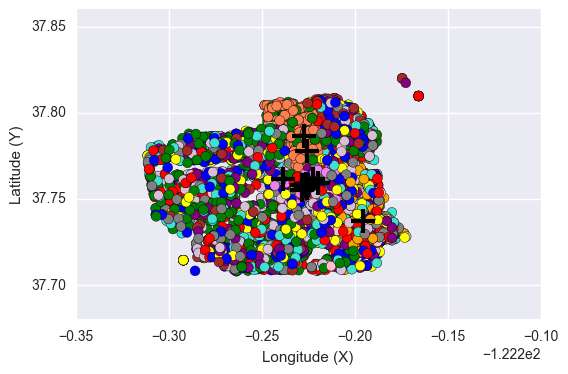

In [46]:
%%time
# scatter plot of X=Longitude versus Y=Latitude, colored by cluster (0=red, 1=green, 2=blue, 3=yellow, 4=purple, 5=gray)
plt.scatter(X_combine.X, X_combine.Y, c=colors[list(X_combine.cluster)], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.X, centers.Y, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')

In [47]:
# %%time
# # scatter plot matrix (0=red, 1=green, 2=blue)
# pd.scatter_matrix(X, c=colors[list(X_combine.cluster)], figsize=(10,10), s=100)

In [48]:
%%time
# center and scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print len(X_scaled)

7523
Wall time: 15 ms


In [49]:
%%time
# K-means with 3 clusters on scaled data
km = KMeans(n_clusters=13, random_state=42)
km.fit(X_scaled)

Wall time: 910 ms


In [50]:
%%time
X_combine['cluster'] = km.labels_
X_combine.sort_values(by='cluster')

Wall time: 5 ms


In [51]:
%%time
# review the cluster centers
X_combine.groupby('cluster').mean()

Wall time: 16 ms


,Descript_ATTEMPTED STOLEN VEHICLE,"Descript_AUTO, GRAND THEFT OF",Descript_STOLEN AND RECOVERED VEHICLE,Descript_STOLEN AUTOMOBILE,Descript_STOLEN BUS,Descript_STOLEN MISCELLANEOUS VEHICLE,Descript_STOLEN MOTORCYCLE,Descript_STOLEN TRAILER,Descript_STOLEN TRUCK,"Descript_VEHICLE, RENTAL, FAILURE TO RETURN",...,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,Resolve
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.010490,0.003497,0.081585,0.562937,0.000000,0.0,0.124709,0.0,0.216783,0.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.427598,37.786627,0.109557
1,0.001739,0.001739,0.060870,0.589565,0.000000,0.0,0.080000,0.0,0.266087,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-122.469538,37.780564,0.097391
2,0.006329,0.008137,0.062387,0.568716,0.000000,0.0,0.118445,0.0,0.235986,0.0,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.420228,37.759018,0.067812
3,0.011765,0.000000,0.064706,0.525490,0.000000,0.0,0.200000,0.0,0.198039,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-122.443654,37.769392,0.082353
4,0.009509,0.000000,0.052298,0.633914,0.000000,0.0,0.061807,0.0,0.242472,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-122.477468,37.738646,0.077655
5,0.009355,0.001871,0.065482,0.596819,0.000935,0.0,0.063611,0.0,0.261927,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.427935,37.729473,0.048644
6,0.009592,0.000000,0.085532,0.549161,0.000000,0.0,0.063149,0.0,0.292566,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.394887,37.737592,0.079936
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,...,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,-122.406381,37.751536,0.125000
8,0.023448,0.006897,0.081379,0.548966,0.000000,0.0,0.125517,0.0,0.213793,0.0,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-122.404270,37.779625,0.111724


In [52]:
# %%time
# # scatter plot matrix of new cluster assignments (0=red, 1=green, 2=blue)
# pd.scatter_matrix(X, c=colors[list(X_combine.cluster)], figsize=(10,10), s=100)

In [53]:
%%time
# calculate SC for K=13
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

Wall time: 4.06 s


In [54]:
%%time
# calculate SC for K=2 through K=19
k_range = range(2, 20)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

Wall time: 1min 36s


Wall time: 152 ms


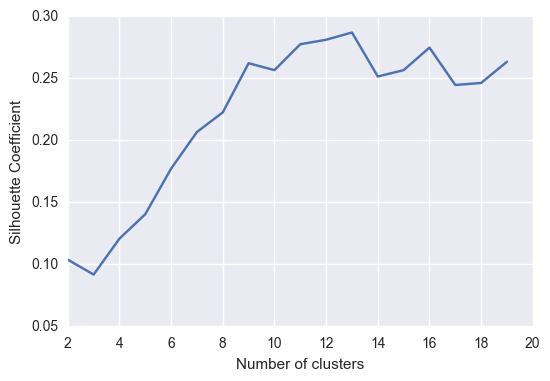

In [55]:
%%time
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

Wall time: 621 ms


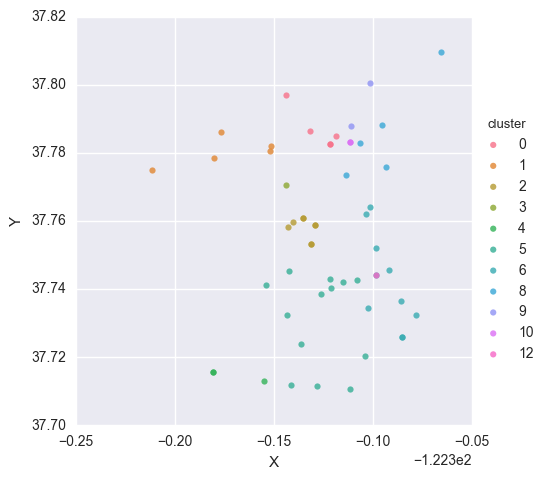

In [66]:
%%time
date_start = '2016-01-01'
date_end = '2016-01-31'
days = pd.to_datetime(date_end) - pd.to_datetime(date_start)
days = days.days
plot_data = X_combine[(date_start):(date_end)]
dates = []

X_plot = plot_data[['X','Y','cluster']]

sb.lmplot('X', 'Y',
           data=X_plot,
           fit_reg=False,
           hue='cluster'
         )

In [57]:
len(X_combine['cluster'])

7523

In [58]:
X_combine

Descript_ATTEMPTED STOLEN VEHICLE  \
Date       Time                                       
2016-01-01 00:01                                  0   
           01:30                                  0   
           09:00                                  0   
           09:00                                  0   
           09:00                                  0   
           11:00                                  0   
           11:30                                  0   
           11:50                                  0   
           12:00                                  0   
           12:00                                  0   
           12:00                                  0   
           12:00                                  0   
           12:00                                  0   
           15:00                                  0   
           18:00                                  0   
           18:00                                  0   
           18:00                                  0   
           18:00                                  0   
           20:30                                  0   
           22:30                                  0   
2016-01-02 02:12                                  0   
           02:12                                  0   
           03:49                                  0   
           03:49                                  0   
           05:30                                  0   
           08:00                                  0   
           12:21                                  0   
           12:30                                  0   
           13:00                                  0   
           14:00                                  0   
...                                             ...   
2017-03-06 22:30                                  0   
           23:00                                  0   
2017-03-07 01:45                                  0   
           06:00                                  0   
           07:00                                  0   
           13:00                                  0   
           16:00                                  0   
           18:00                                  0   
           20:00                                  0   
           21:50                                  0   
           22:00                                  0   
           22:00                                  0   
           23:30                                  0   
2017-03-08 10:00                                  0   
           11:30                                  0   
           12:00                                  0   
           14:00                                  0   
           17:00                                  0   
           17:00                                  0   
           18:30                                  0   
           19:00                                  0   
           19:00                                  0   
           20:00                                  0   
           21:00                                  0   
           21:30                                  0   
           22:00                                  0   
           23:06                                  0   
           23:15                                  0   
           23:15                                  0   
           23:28                                  0   

                  Descript_AUTO, GRAND THEFT OF  \
Date       Time                                   
2016-01-01 00:01                              0   
           01:30                              0   
           09:00                              0   
           09:00                              0   
           09:00                              0   
           11:00                              0   
           11:30                              0   
           11:50                              0   
           12:00                          

In [59]:
%%time
# Extract feature columns
feature_cols = list(X_combine.drop(['Resolve'], axis=1))

# Extract target column 'passed'
target_col = X_combine.columns[-1]

# Number of features
num_features = len(feature_cols)

# Show the list of columns
print "Number of Features: {}".format(num_features)
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

Number of Features: 30
Feature columns:
['Descript_ATTEMPTED STOLEN VEHICLE', 'Descript_AUTO, GRAND THEFT OF', 'Descript_STOLEN AND RECOVERED VEHICLE', 'Descript_STOLEN AUTOMOBILE', 'Descript_STOLEN BUS', 'Descript_STOLEN MISCELLANEOUS VEHICLE', 'Descript_STOLEN MOTORCYCLE', 'Descript_STOLEN TRAILER', 'Descript_STOLEN TRUCK', 'Descript_VEHICLE, RENTAL, FAILURE TO RETURN', 'DayOfWeek_Friday', 'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN', 'X', 'Y', 'cluster']

Target column: cluster
Wall time: 3 ms


In [60]:
%%time
# fit a linear regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
X = X_combine[feature_cols]
y = X_combine[target_col]

model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
print model.score(X, y)

0.998271965971
Wall time: 990 ms


In [61]:
%%time
# dates = X_dates.reset_index().drop('IncidntNum', axis=1)['Date']
# dates = pd.to_datetime(dates).unique()
# cdate = pd.to_datetime(dates[10]).strftime('%Y-%m-%d')
# print len(dates)
# print dates
# print cdate

Wall time: 0 ns


In [62]:
%%time
# times = X_dates.reset_index().drop('IncidntNum', axis=1)
# times = times[times.Date == cdate]['Time']
# times = times.unique()
# ctime = times[3]
# print len(times)
# print ctime

Wall time: 0 ns


In [63]:
%%time
# long = X_combine[(cdate, ctime):(cdate, ctime)][('X')]
# print len(long)
# print long[0]

Wall time: 0 ns


In [64]:
%%time
# lat = X_combine[(cdate, ctime):(cdate, ctime)][('Y')]
# print len(lat)
# print lat[0]

Wall time: 0 ns


In [65]:
%%time
# for i in range(0,3):
#     for j in range(0,10):
#         print "[%d, %d]" % (i,j)

Wall time: 0 ns


In [88]:
%%time
# Get all unique dates into an array to read through each date
dates = X_dates.reset_index().drop('IncidntNum', axis=1)['Date']
dates = pd.to_datetime(dates).unique()
print len(dates)
times = X_dates.reset_index().drop('IncidntNum', axis=1)
print len(times)
magnitude = []
degree = []
count = 0

433
7540
Wall time: 10 ms


In [114]:
check = times[times.Date=='2016-02-02'][times.Time=='18:00']
check.Date
# cdate = pd.to_datetime(check.Date).strftime('%Y-%m-%d')

C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


597   2016-02-02
Name: Date, dtype: datetime64[ns]

In [115]:
X_combine[('2016-02-02','18:00'):('2016-02-02', '18:00')]

,,Descript_ATTEMPTED STOLEN VEHICLE,"Descript_AUTO, GRAND THEFT OF",Descript_STOLEN AND RECOVERED VEHICLE,Descript_STOLEN AUTOMOBILE,Descript_STOLEN BUS,Descript_STOLEN MISCELLANEOUS VEHICLE,Descript_STOLEN MOTORCYCLE,Descript_STOLEN TRAILER,Descript_STOLEN TRUCK,"Descript_VEHICLE, RENTAL, FAILURE TO RETURN",...,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,Resolve,cluster
Date,Time,,,,,,,,,,,,,,,,,,,,,
2016-02-02,18:00,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,-122.438546,37.801285,0,0


In [90]:
%%time
# Read through each Date and Time to calculate the Magnitude and Degrees
# for i in range(0,len(dates)):
if 200 > len(dates):
    end = len(dates)
else:
    end = 200
for i in range(0, end):
    '''Get all times per date into an array to read through each time on each date for calculations'''
    fdate = pd.to_datetime(dates[i]).strftime('%Y-%m-%d')
#     print fdate
    utimes = times[times.Date == fdate]['Time']
#     print utimes
    utime = utimes.unique()
#     print "Fixed Date: %s" % fdate
#     print "Unique Time: %s # of Times: %d" % (utime,len(utime))
    for j in range(0, len(utime)):
        if j == len(utime)-1:
            magnitude.append([0])
            degree.append([0])
        else:
            '''curr is the current time'''
            '''nex is the next time'''
            curr = utime[j]
#             print fdate
#             print curr
            nex = utime[j+1]
            '''long1 is the Longitude of the Unique Next time'''
            '''long0 is the Longitude of the Unique Current time'''
            '''lat1 is the Latitude of the Unique  Next time'''
            '''lat0 is the Latitude of the Unique Current time'''
            rep = len(X_combine[(fdate, nex):(fdate, nex)][('X')])
            long1 = X_combine[(fdate, nex):(fdate, nex)][('X')][0]
            long0 = X_combine[(fdate, curr):(fdate, curr)][('X')][0]
            lat1 = X_combine[(fdate, nex):(fdate, nex)][('Y')][0]
            lat0 = X_combine[(fdate, curr):(fdate, curr)][('Y')][0]
            magnitude.append([math.sqrt((long1-long0)**2 + (lat1-lat0)**2)] * rep)
            degree.append([math.degrees(math.atan((lat1-lat0)/(long1-long0)))] * rep)
#             print "long0:"
#             print long0
#             print "long1:"
#             print long1
#             print "lat0:"
#             print lat0
#             print "lat1:"
#             print lat1
#         print count
#         print magnitude
#         print degree
#         print rep
        count += 1

2016-01-01
00:01
2016-01-01
01:30
2016-01-01
09:00
2016-01-01
11:00
2016-01-01
11:30
2016-01-01
11:50
2016-01-01
12:00
2016-01-01
15:00
2016-01-01
18:00
2016-01-01
20:30
2016-01-02
02:12
2016-01-02
03:49
2016-01-02
05:30
2016-01-02
08:00
2016-01-02
12:21
2016-01-02
12:30
2016-01-02
13:00
2016-01-02
14:00
2016-01-02
16:00
2016-01-02
20:30
2016-01-02
21:00
2016-01-02
21:50
2016-01-03
00:01
2016-01-03
03:00
2016-01-03
08:00
2016-01-03
09:00
2016-01-03
15:00
2016-01-03
15:40
2016-01-03
16:00
2016-01-03
17:00
2016-01-03
18:00
2016-01-03
18:39
2016-01-03
19:40
2016-01-03
22:00
2016-01-03
23:00
2016-01-04
00:01
2016-01-04
02:30
2016-01-04
08:00
2016-01-04
09:00
2016-01-04
15:27
2016-01-04
18:30
2016-01-04
19:50
2016-01-04
21:00
2016-01-04
22:00
2016-01-05
01:30
2016-01-05
01:45
2016-01-05
04:04
2016-01-05
05:25
2016-01-05
06:30
2016-01-05
06:40
2016-01-05
07:26
2016-01-05
12:00
2016-01-05
16:00
2016-01-05
18:30
2016-01-05
19:00
2016-01-05
19:10
2016-01-05
19:45
2016-01-05
20:00
2016-01-06
08:

C:\Users\morebeus\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: invalid value encountered in double_scalars


2016-02-02
18:00
2016-02-02
18:40
2016-02-02
19:00
2016-02-02
19:24
2016-02-02
19:30
2016-02-02
20:00
2016-02-02
21:00
2016-02-02
21:30
2016-02-03
07:48
2016-02-03
14:47
2016-02-03
17:15
2016-02-03
17:30
2016-02-03
18:30
2016-02-03
19:00
2016-02-03
19:12
2016-02-03
21:30
2016-02-03
22:00
2016-02-04
01:00
2016-02-04
02:00
2016-02-04
08:00
2016-02-04
08:30
2016-02-04
10:35
2016-02-04
12:00
2016-02-04
16:00
2016-02-04
18:00
2016-02-04
19:00
2016-02-04
20:00
2016-02-04
21:00
2016-02-05
01:00
2016-02-05
02:00
2016-02-05
10:00
2016-02-05
12:00
2016-02-05
15:30
2016-02-05
17:00
2016-02-05
18:00
2016-02-05
18:26
2016-02-05
18:30
2016-02-05
18:45
2016-02-05
19:00
2016-02-05
19:30
2016-02-05
19:45
2016-02-05
20:00
2016-02-05
20:30
2016-02-05
22:00
2016-02-06
01:00
2016-02-06
06:30
2016-02-06
10:00
2016-02-06
11:00
2016-02-06
12:00
2016-02-06
14:00
2016-02-06
15:00
2016-02-06
18:30
2016-02-06
21:37
2016-02-06
21:40
2016-02-06
23:00
2016-02-06
23:20
2016-02-07
00:30
2016-02-07
01:00
2016-02-07
02:

In [91]:
%%time
print i
print count
print magnitude[count]
print degree[count]

199
2616


IndexError: list index out of range

In [ ]:
%%time
# Read through each Date and Time to calculate the Magnitude and Degrees
# for i in range(0,len(dates)):
k = i
if (k+201) > len(dates):
    end = len(dates)
else:
    end = k+201
for i in range(k+1, end):
    '''Get all times per date into an array to read through each time on each date for calculations'''
    fdate = pd.to_datetime(dates[i]).strftime('%Y-%m-%d')
#     print fdate
    utimes = times[times.Date == fdate]['Time']
#     print utimes
    utime = utimes.unique()
#     print "Fixed Date: %s" % fdate
#     print "Unique Time: %s # of Times: %d" % (utime,len(utime))
    for j in range(0, len(utime)):
        if j == len(utime)-1:
            magnitude.append([0])
            degree.append([0])
        else:
            '''curr is the current time'''
            '''nex is the next time'''
            curr = utime[j]
            nex = utime[j+1]
            '''long1 is the Longitude of the Unique Next time'''
            '''long0 is the Longitude of the Unique Current time'''
            '''lat1 is the Latitude of the Unique  Next time'''
            '''lat0 is the Latitude of the Unique Current time'''
            rep = len(X_combine[(fdate, nex):(fdate, nex)][('X')])
            long1 = X_combine[(fdate, nex):(fdate, nex)][('X')][0]
            long0 = X_combine[(fdate, curr):(fdate, curr)][('X')][0]
            lat1 = X_combine[(fdate, nex):(fdate, nex)][('Y')][0]
            lat0 = X_combine[(fdate, curr):(fdate, curr)][('Y')][0]
            magnitude.append([math.sqrt((long1-long0)**2 + (lat1-lat0)**2)] * rep)
            degree.append([math.degrees(math.atan((lat1-lat0)/(long1-long0)))] * rep)
#             print "long0:"
#             print long0
#             print "long1:"
#             print long1
#             print "lat0:"
#             print lat0
#             print "lat1:"
#             print lat1
        print count
#         print magnitude
#         print degree
#         print rep
        count += 1

In [ ]:
%%time
print i
print count
print magnitude[count]
print degree[count]

In [ ]:
%%time
# Read through each Date and Time to calculate the Magnitude and Degrees
# for i in range(0,len(dates)):
k = i
if (k+201) > len(dates):
    end = len(dates)
else:
    end = k+201
for i in range(k+1, end):
    '''Get all times per date into an array to read through each time on each date for calculations'''
    fdate = pd.to_datetime(dates[i]).strftime('%Y-%m-%d')
#     print fdate
    utimes = times[times.Date == fdate]['Time']
#     print utimes
    utime = utimes.unique()
#     print "Fixed Date: %s" % fdate
#     print "Unique Time: %s # of Times: %d" % (utime,len(utime))
    for j in range(0, len(utime)):
        if j == len(utime)-1:
            magnitude.append([0])
            degree.append([0])
        else:
            '''curr is the current time'''
            '''nex is the next time'''
            curr = utime[j]
            nex = utime[j+1]
            '''long1 is the Longitude of the Unique Next time'''
            '''long0 is the Longitude of the Unique Current time'''
            '''lat1 is the Latitude of the Unique  Next time'''
            '''lat0 is the Latitude of the Unique Current time'''
            rep = len(X_combine[(fdate, nex):(fdate, nex)][('X')])
            long1 = X_combine[(fdate, nex):(fdate, nex)][('X')][0]
            long0 = X_combine[(fdate, curr):(fdate, curr)][('X')][0]
            lat1 = X_combine[(fdate, nex):(fdate, nex)][('Y')][0]
            lat0 = X_combine[(fdate, curr):(fdate, curr)][('Y')][0]
            magnitude.append([math.sqrt((long1-long0)**2 + (lat1-lat0)**2)] * rep)
            degree.append([math.degrees(math.atan((lat1-lat0)/(long1-long0)))] * rep)
#             print "long0:"
#             print long0
#             print "long1:"
#             print long1
#             print "lat0:"
#             print lat0
#             print "lat1:"
#             print lat1
        print count
#         print magnitude
#         print degree
#         print rep
        count += 1

In [ ]:
print i
print count
print magnitude[count]
print degree[count]

In [ ]:
len(X_combine.cluster)

In [ ]:
# X_combine.info()

In [ ]:
magnitude = [y for x in magnitude for y in x]
degree = [y for x in degree for y in x]
print len(magnitude)
print len(degree)
# print magnitude
# print degree

In [142]:
X_combine['Magnitude'] = magnitude
X_combine['Degree'] = degree

ValueError: Length of values does not match length of index

In [ ]:
%%time
X_combine.info()

In [ ]:
train = X_combine[:('2017-03-01', '00:00')]
test = X_combine[('2017-03-01', '00:00'):]